## Boundary Layer Model - V02

Comparison with RAD data collocated to SAR

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

import warnings
warnings.filterwarnings("ignore")

In [2]:
PTHS = {
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/11_BL_v02_comp_wRAD/',
    'collocs_pth': '/home/arthur/results/ck22model/Radiometer_MAXSS/02_colocate_rad_sar/ds_col_rad_sar.nc'
}

In [3]:
####-----------####
#### FUNCTIONS ####
####-----------####

### MODEL
def coriolis(lat):
    '''Absolute vorticity.
    Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat, vmin=0):
    '''Holland 1980 profile.'''
    fcor = coriolis(lat)
    V    = r * 0.
    V    = vmin + np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def willoughby_profile_no_smooth(r, n, X1, Vmin, Rmax, Vmax):
    '''No polynomial ramp smoothing here.
    We assume V(0) = Vmin != 0 to fit SAR data'''
    V    = r * 0.
    Vinf = (Vmax - Vmin) * ((r / Rmax) ** n) + Vmin
    Vsup = (Vmax - Vmin) * np.exp((-1.) * ((r - Rmax) / X1)) + Vmin
    V[r <=Rmax] = Vinf[r <=Rmax]
    V[r > Rmax] = Vsup[r > Rmax]
    return V

In [4]:
# Inertial stability
def I(r, v, fcor):
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * v / r + fcor
    zeta = np.gradient(v, dr) + v / r + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(r, V, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.unique(np.diff(r))[0] # meters
    ksi  = 2 * V / r + fcor
    zeta = np.gradient(V, dr) + V / r + fcor
    return np.sqrt(ksi / zeta)

def eta(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * ((V / r) + I(r, V, fcor))))

def ki(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / (K * I(r, V, fcor)))

def psi(r, V, K, C, fcor):
    return C * V * np.sqrt(2 / abs(K * ((V / r) - I(r, V, fcor))))

# Amplitudes
def A0(r, V, K, C, fcor):
    num = -ki(r, V, K, C, fcor) * V * [1 + 1j * (1 + ki(r, V, K, C, fcor))]
    den = 2 * ki(r, V, K, C, fcor) ** 2 + 3 * ki(r, V, K, C, fcor) + 2
    return num / den

def A1(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * eta(r, V, K, C, fcor) + 3j * psi(r, V, K, C, fcor)]
    return num / den

def A_1(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [(2 + 2j) * (1 + eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)) + 3 * psi(r, V, K, C, fcor) + 3j * eta(r, V, K, C, fcor)]
    return num / den

def A1_prime(r, V, Ut, K, C, fcor):
    num = -eta(r, V, K, C, fcor) * Ut * [1 - 2 * sqrt_alpha_beta(r, V, fcor) + (1 - 1j) * (1 - sqrt_alpha_beta(r, V, fcor)) * psi(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 + 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 - 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

def A_1_prime(r, V, Ut, K, C, fcor):
    num = -psi(r, V, K, C, fcor) * Ut * [1 + 2 * sqrt_alpha_beta(r, V, fcor) + (1 + 1j) * (1 + sqrt_alpha_beta(r, V, fcor)) * eta(r, V, K, C, fcor)]
    den = sqrt_alpha_beta(r, V, fcor) * [2 - 2j + 3 * (eta(r, V, K, C, fcor) + psi(r, V, K, C, fcor)) + (2 + 2j) * eta(r, V, K, C, fcor) * psi(r, V, K, C, fcor)]
    return num / den

# Radial and tangential wind components at the surface (z = 0)
def u0(r, V, K, C, fcor):
    return np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A0(r, V, K, C, fcor)))

def v0(r, V, K, C, fcor):
    return np.squeeze(np.imag(A0(r, V, K, C, fcor)))

def u1(theta, r, V, Ut, K, C, fcor):
    u1        = V * 0
    msk       = I(r, V, fcor) >= V / r
    u1[msk]   = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    u1[~msk]  = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return u1

def v1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A1(r, V, Ut, K, C, fcor)       * np.exp(1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A1_prime(r, V, Ut, K, C, fcor) * np.exp(1j * theta)))[~msk]
    return v1

def u_1(theta, r, V, Ut, K, C, fcor):
    u1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    u1[msk] = np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    u1[~msk]= np.squeeze(sqrt_alpha_beta(r, V, fcor) * np.real(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return u1

def v_1(theta, r, V, Ut, K, C, fcor):
    v1      = V * 0
    msk     = I(r, V, fcor) >= V / r
    v1[msk] = np.squeeze(np.imag(A_1(r, V, Ut, K, C, fcor)       * np.exp(-1j * theta)))[msk]
    v1[~msk]= np.squeeze(np.imag(A_1_prime(r, V, Ut, K, C, fcor) * np.exp(-1j * theta)))[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(theta, r, V, Ut, K, C, fcor):
    return u_1(theta, r, V, Ut, K, C, fcor) + u0(r, V, K, C, fcor) + u1(theta, r, V, Ut, K, C, fcor)

def v_BL(theta, r, V, Ut, K, C, fcor):
    return V + v_1(theta, r, V, Ut, K, C, fcor) + v0(r, V, K, C, fcor) + v1(theta, r, V, Ut, K, C, fcor)

In [5]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def get_V_tot_BL(vmx, rmx, B, lat, Ut, vmn=0, K=50, C=2.5e-3):
    # Initialize grids
    rs      = np.linspace(10, 8e5, 800)
    ths     = np.linspace(0, 2 * np.pi, 361)
    Rs, THs = np.meshgrid(rs, ths)
    Us      = np.ones_like(Rs)
    Vs      = np.ones_like(Rs)
    
    # Compute V holland
    V = h80(rs, vmx, rmx, B, lat, vmn)
    
    # Assign surface winds inside BL
    for i, th in enumerate(ths):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, coriolis(lat))
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, coriolis(lat))
        
    # Add storm speed vector
    Us       = Us + Ut * np.cos(THs)
    Vs       = Vs - Ut * np.sin(THs)
    
    # Compute total BL wind
    V_tot_BL = np.sqrt(Vs ** 2 + Us ** 2)
    
    # Define cartesian grids 
    Xs, Ys   = pol2cart(Rs, THs + np.pi/2)
    
    return V_tot_BL, Xs, Ys

def get_V_tot_BL_will(n, X1, vmn, rmx, vmx, lat, Ut, K=50, C=2.5e-3):
    # Initialize grids
    rs      = np.linspace(10, 8e5, 800)
    ths     = np.linspace(0, 2 * np.pi, 361)
    Rs, THs = np.meshgrid(rs, ths)
    Us      = np.ones_like(Rs)
    Vs      = np.ones_like(Rs)
    
    # Compute V will
    V = willoughby_profile_no_smooth(rs / 1000, n, X1, vmn, rmx, vmx)
    
    # Assign surface winds inside BL
    for i, th in enumerate(ths):
        Us[i, :] = u_BL(th, rs, V, Ut, K, C, coriolis(lat))
        Vs[i, :] = v_BL(th, rs, V, Ut, K, C, coriolis(lat))
        
    # Add storm speed vector
    Us       = Us + Ut * np.cos(THs)
    Vs       = Vs - Ut * np.sin(THs)
    
    # Compute total BL wind
    V_tot_BL = np.sqrt(Vs ** 2 + Us ** 2)
    
    # Define cartesian grids 
    Xs, Ys   = pol2cart(Rs, THs + np.pi/2)
    
    return V_tot_BL, Xs, Ys

def std_prof(V):
    return np.std(V / np.nanmax(V), axis=0)

In [6]:
### OPEN SAR DATA
dsg  = xr.open_dataset('/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc')
dsg2 = xr.open_dataset('/home/arthur/results/TCsLifeMonitFromObs/07_SAR_K10/ds_glob.nc')
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### OPEN COLLOCS
ds_col = xr.open_dataset(PTHS['collocs_pth'])

In [57]:
listOfDatasets = []

for i, _ in tqdm(enumerate(ds_col.i)):
    # Open files
    dsc         = ds_col.isel(i=i)
    sar_pth     = dsc.sar_pth.item()
    rad_pth     = dsc.rad_pth.item()
    ds_sar      = xr.open_dataset(sar_pth).isel(time=0)
    ds_rad      = xr.open_dataset(rad_pth)
    ds_rad_car  = xr.open_dataset('/'.join(rad_pth.split('/')[:7]) + '/CARTESIAN/' + '/'.join(rad_pth.split('/')[-3:-1]) + '/CAR' + rad_pth.split('/')[-1][3:])
    
    # Title
    strm_info = '{}, {}'.format(ds_sar.attrs['Storm name'], ds_sar.attrs['Storm ID'].upper())
    title     = strm_info + '\nSAR: {}\n{}: {}'.format('/'.join(sar_pth.split('/')[-2:]), dsc.rad_mission.item().upper(), '/'.join(rad_pth.split('/')[-5:]))
    fig, axs  = plt.subplots(nrows=2, ncols=2, figsize=(30, 23))
    fig.suptitle(title)

    # Prepare colorbar
    cmap       = plt.get_cmap('jet')
    normalizer = Normalize(0, max(np.nanmax(ds_sar['wind_speed']), np.nanmax(ds_rad_car['wind_speed'])))

    # 1) SAR
    ax = axs[0, 0]
    ax.set_title('SAR', fontsize=16, weight='bold')
    y_sar, x_sar = pol2cart(ds_sar['rad'], np.deg2rad(ds_sar['theta']))
    im = ax.pcolormesh(x_sar / 1000, y_sar / 1000, ds_sar['wind_speed'], cmap=cmap, norm=normalizer)
    ax.set_xlabel('x (km)');ax.set_ylabel('y (km)');ax.grid()

    x_lim = int(np.nanmax(x_sar.where(~np.isnan(ds_sar['wind_speed']))) / 1000)
    y_lim = int(np.nanmax(y_sar.where(~np.isnan(ds_sar['wind_speed']))) / 1000)
    limit = np.max((x_lim, y_lim))
    ax.set_xlim(-limit, limit);ax.set_ylim(-limit, limit)

    # 2) RAD
    ax = axs[0, 1]
    ax.set_title('{}'.format(dsc.rad_mission.item().upper()), fontsize=16, weight='bold')
    x_rad, y_rad = np.meshgrid(ds_rad_car.x, ds_rad_car.y)
    ax.pcolormesh(x_rad / 1000, y_rad / 1000, ds_rad_car['wind_speed'], cmap=cmap, norm=normalizer)
    ax.set_xlabel('x (km)');ax.set_ylabel('y (km)');ax.grid()
    ax.set_xlim(-limit, limit);ax.set_ylim(-limit, limit)

    # Colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.81, 0.53, 0.02, 0.35])
    cbar    = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Wind speed (m/s)', rotation=270, fontsize=16)
    cbar.ax.get_yaxis().labelpad=20

    # 3) WIND SPEED PROFILES
    gs = ax.get_gridspec()
    axs[1, 0].remove(), axs[1, 1].remove()
    ax = fig.add_subplot(gs[1, :])
    # SAR
    std_prof_sar = (ds_sar.wind_speed / ds_sar.wind_speed.max(dim=['rad', 'theta'])).std(dim='theta', skipna=True)
    ax.plot(std_prof_sar.rad / 1000, std_prof_sar, c='k', linewidth=3, label='SAR')
    # RAD
    std_prof_rad = (ds_rad.wind_speed / ds_rad.wind_speed.max(dim=['rad', 'theta'])).std(dim='theta', skipna=True)
    ax.plot(std_prof_rad.rad, std_prof_rad, c='tab:blue', linewidth=3, label='{}'.format(dsc.rad_mission.item().upper()))
    # Validity of RAD
    valids = ds_rad.where(ds_rad.wind_speed.notnull().sum(dim='theta') > 200, drop=True)
    if len(valids.rad) > 2:
        ax.axvspan(valids.rad[0], valids.rad[-1], facecolor='tab:green', alpha=0.2, label='Valid area')
        
        
    ### KEPERT MODEL BASED ON SAR AND PLOT
    dss = dsg.where(dsg.sat_pth == sar_pth, drop=True).isel(time=0)
    # Willoughby version
    n_sar   = float(dss.n_will)
    X1_sar  = float(dss.X1_will)
    vmn_sar = float(dss.Vmin_will)
    rmx_sar = float(dss.Rmax_will)
    vmx_sar = float(dss.Vmax_will)
    lat_sar = float(abs(dss.lat_center))
    Ut_sar  = float(dss.cyclone_speed)
    V_tot, Xs, Ys = get_V_tot_BL_will(n_sar, X1_sar, vmn_sar, rmx_sar, vmx_sar, lat_sar, Ut_sar)    
    B_sar   = float(dss.B_hol)
    
    # Asymmetries
    rs           = np.linspace(10, 8e5, 800)
    std_prof_k01 = std_prof(V_tot)
    ax.plot(rs / 1000, std_prof_k01, c='tab:green', linewidth=3, label='Model - K01')
    ax.set_xlim(0, 800)
    
    # Axes, legend
    ax.set_xlabel('r (km)');ax.set_ylabel('Asymmetry');ax.grid();ax.legend()
    
    # Save
    # plt.savefig(PTHS['sav_dir'] + '{0:03}'.format(i) + '_{}_{}_{}'.format(ds_sar.attrs['Storm name'], ds_sar.attrs['Storm ID'].upper(), os.path.basename(sar_pth)[:-3]));plt.clf()
    plt.clf()
    
    # Compute error of model
    if len(valids.rad) > 2:
        if (ds_sar.wind_speed.sel(rad=slice(0, 100000)).notnull().sum() > 25000) and (valids.rad[-1] > 200): # possible points: 101 * 360 = 36360
            # print('ok')
            ds_itp = xr.Dataset(
                data_vars={
                    'std_prof_rad': std_prof_rad.interp({'rad': rs / 1000}),
                }
            )
            ds_itp['std_prof_k01'] = ('rad', std_prof_k01)
            ds_itp_val = ds_itp.sel(rad=slice(200, valids.rad[-1]))

            dss['asym_mean_bias'] = (ds_itp_val['std_prof_rad'] - ds_itp_val['std_prof_k01']).mean(dim='rad', skipna=True)
            # dss['asym_mean_std']  = (ds_itp_val['std_prof_rad'] - ds_itp_val['std_prof_k01']).std(dim='rad', skipna=True)
            listOfDatasets.append(dss)

0it [00:00, ?it/s]

Exception ignored in: <function TransformNode.set_children.<locals>.<lambda> at 0x7fb4058a8040>
Traceback (most recent call last):
  File "/home/arthur/.local/lib/python3.8/site-packages/matplotlib/transforms.py", line 222, in <lambda>
    self, lambda _, pop=child._parents.pop, k=id(self): pop(k))
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x7fb40b42a040> (for post_execute):



KeyboardInterrupt



In [13]:
print('Concatenating all datasets into ds_glob. Can take a few seconds...')
dsg = xr.concat(listOfDatasets, dim='time') # Concatenate all datasets into a global dataset
print('Concatenation ended.')

Concatenating all datasets into ds_glob. Can take a few seconds...
Concatenation ended.


In [78]:
# Save
# dsg.to_netcdf(PTHS['sav_dir'] + 'dsg.nc')
# Open
dsg = xr.open_dataset(PTHS['sav_dir'] + 'dsg.nc')

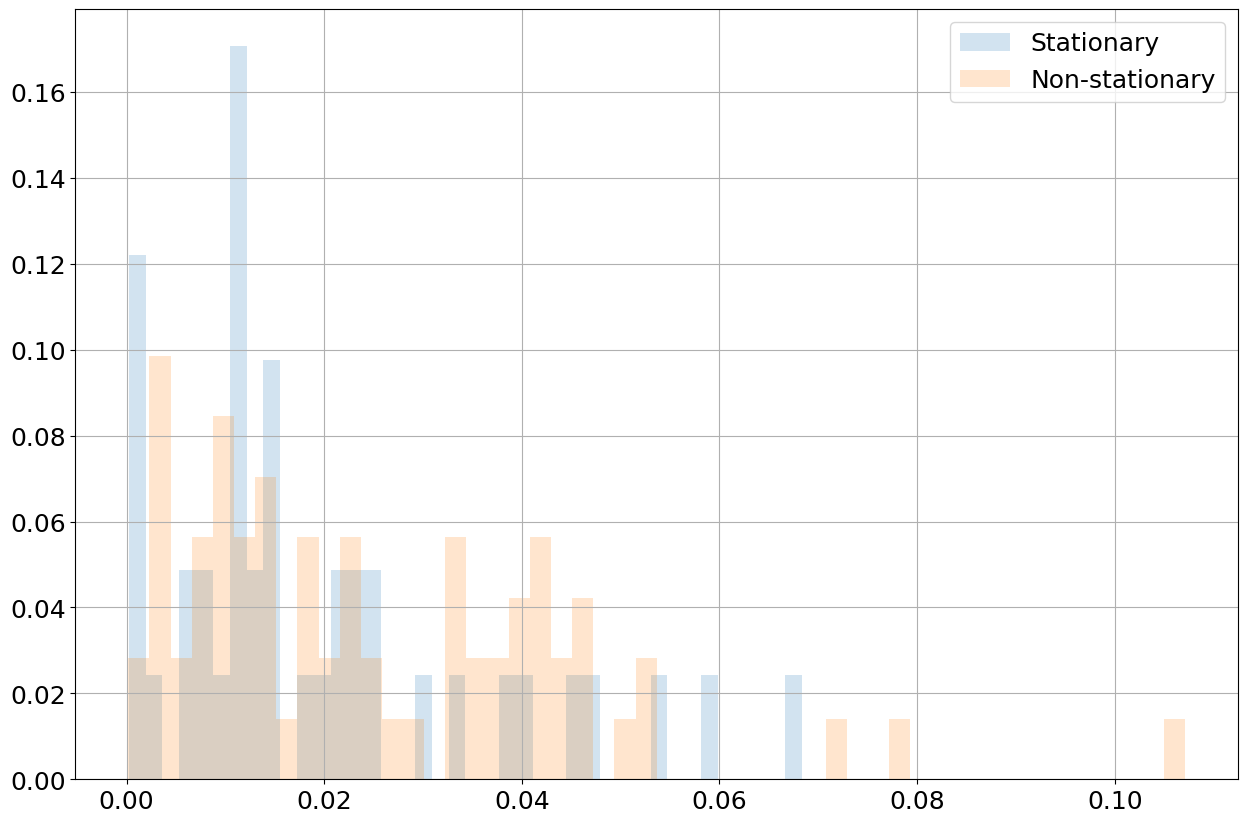

In [83]:
d = dsg.where(abs(dsg.lat_center) < 30, drop=True)
d = d.where(d.Vmax_1D >= 20, drop=True)
d = d.where(d.distance_to_coast > 200000, drop=True)
d = d.where(d.Rmax_1D < 50, drop=True)

d_stat = d.where(abs(d.Vmax_dot_smth_IBT) < 0.3, drop=True)
d_ints = d.where(abs(d.Vmax_dot_smth_IBT) > 0.3, drop=True)

plt.hist(abs(d_stat.asym_mean_bias), weights=np.zeros_like(abs(d_stat.asym_mean_bias)) + 1. / abs(d_stat.asym_mean_bias).size, alpha=0.2, bins=40, label='Stationary')
plt.hist(abs(d_ints.asym_mean_bias), weights=np.zeros_like(abs(d_ints.asym_mean_bias)) + 1. / abs(d_ints.asym_mean_bias).size, alpha=0.2, bins=50, label='Non-stationary')
plt.grid();plt.legend()